# London Bike-Share — Policy Overlay (PTAL / IMD / Cycle / Tube)
This notebook helps you **overlay clustered stations** on policy layers and export attributes for analysis.

**What it produces**
- Maps (PNG): PTAL+clusters, IMD+clusters, Cycle Routes+clusters, Underground+clusters
- Joined attributes for each station: `PTAL_point`, `PTAL_mean_250m`, `IMD_decile` (or quintile), distance to Cycle Route / Tube station, plus within-radius flags
- GeoJSON + CSV for downstream plotting/modeling

> Notes
> - Uses only `geopandas`/`pandas`/`matplotlib` (no seaborn).
> - Avoids custom color settings to keep styles simple and consistent.
> - Make sure your station file has `station_id`, `station_name`, `cluster`, and coordinates (`lon`, `lat`) if using CSV.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# 读取数据
df = pd.read_csv("0_try2_data/kmeans3_cluster.csv")

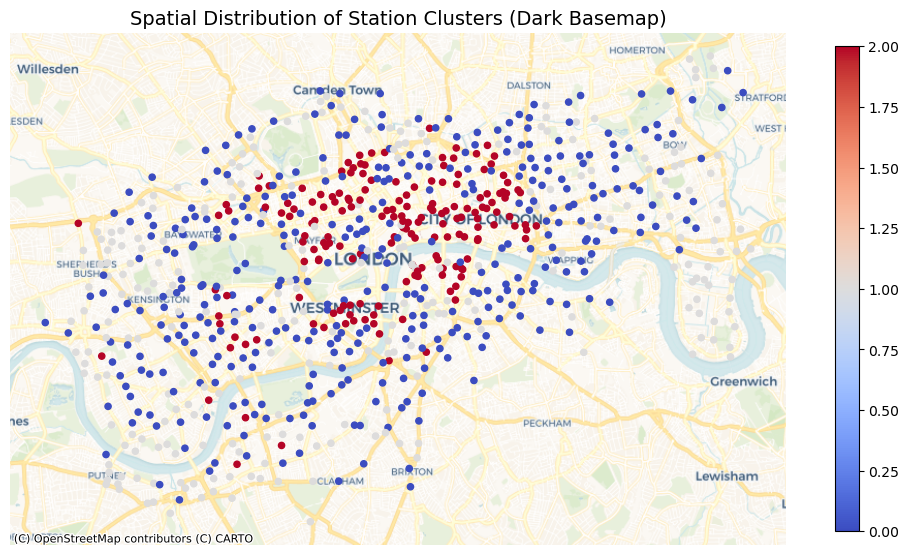

In [2]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point

# 构建 GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# 绘图
fig, ax = plt.subplots(figsize=(10, 10))
plot = gdf.plot(
    ax=ax,
    column='cluster',
    cmap='coolwarm',
    legend=True,
    markersize=20,
    alpha=1,

    legend_kwds={'shrink': 0.5}  # 缩小色带为一半
)

# 添加深色底图：OpenStreetMap.HOT
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

# 样式设置
ax.set_axis_off()
ax.set_title("Spatial Distribution of Station Clusters (Dark Basemap)", fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
# 你的簇分布图绘制完之后
xlim = ax.get_xlim()
ylim = ax.get_ylim()
INNER_EXTENT_3857 = {"xlim": xlim, "ylim": ylim}   # 记录下来（3857坐标）
print(INNER_EXTENT_3857)


{'xlim': (-27662.192149336483, 1051.9357921491971), 'ylim': (6700956.533762003, 6719913.842691942)}


In [4]:
# 保存范围（你已经有了这两行）
xlim = ax.get_xlim()
ylim = ax.get_ylim()
INNER_EXTENT_3857 = {"xlim": xlim, "ylim": ylim}

# 小工具：在任意图上应用同一范围
def apply_inner_extent(ax):
    ax.set_xlim(*INNER_EXTENT_3857["xlim"])
    ax.set_ylim(*INNER_EXTENT_3857["ylim"])


In [5]:
# 0) Imports
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import Point
import matplotlib.pyplot as plt

print("geopandas:", gpd.__version__)

geopandas: 1.0.1


In [6]:
# 1) Paths — CHANGE these to your local files
# Your clustered stations file: either a GeoJSON/GeoPackage with geometry,
# or a CSV with columns: station_id, station_name, lon, lat, cluster

STATIONS_PATH = Path("0_try2_data/kmeans3_cluster.csv")  # or "stations_clusters.csv"

PTAL_PATH = Path("0-policy-data/PTAL_2023_Grid_100mx100m_Data.geojson")
IMD_PATH = Path("0-policy-data/Indices_of_Multiple_Deprivation_(IMD)_2019.geojson")
CYCLE_ROUTES_PATH = Path("0-policy-data/Cycle_Routes.geojson")
UNDERGROUND_PATH = Path("0-policy-data/Underground_Stations.geojson")

# Output directory
OUTDIR = Path("outputs")
OUTDIR.mkdir(exist_ok=True)

In [7]:
def load_stations_csv(path: Path) -> gpd.GeoDataFrame:
    df = pd.read_csv(path)
    # 统一列名
    colmap = {}
    if "id" in df.columns: colmap["id"] = "station_id"
    if "startstation_name" in df.columns: colmap["startstation_name"] = "station_name"
    if "latitude" in df.columns: colmap["latitude"] = "lat"
    if "longitude" in df.columns: colmap["longitude"] = "lon"
    df = df.rename(columns=colmap)

    # 基本字段检查
    need = {"station_id","lat","lon","cluster"}
    missing = need - set(df.columns)
    assert not missing, f"缺少字段: {missing}"

    # 类型与去重
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df.dropna(subset=["lat","lon"]).drop_duplicates(subset=["station_id"])

    # cluster 转整数/类别
    df["cluster"] = pd.to_numeric(df["cluster"], errors="coerce").astype("Int64")

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs=4326)
    return gdf.to_crs(27700)  # 转英国国家格网，后续距离是“米”

stations = load_stations_csv(STATIONS_PATH)

print("stations ok:", stations.shape)
print(stations[["station_id","station_name","cluster","lat","lon"]].head())


stations ok: (795, 44)
       station_id                       station_name  cluster        lat  \
0  BikePoints_864  Abbey Orchard Street, Westminster        2  51.498125   
1  BikePoints_559      Abbotsbury Road, Holland Park        1  51.501391   
2  BikePoints_394    Aberdeen Place, St. John's Wood        0  51.524826   
3  BikePoints_554           Aberfeldy Street, Poplar        1  51.513548   
4  BikePoints_583        Abingdon Green, Westminster        2  51.497640   

        lon  
0 -0.132102  
1 -0.205991  
2 -0.176268  
3 -0.005659  
4 -0.125972  


In [16]:
import geopandas as gpd
from shapely.geometry import Point

BNG_EPSG = 27700   # British National Grid

def to_bng(gdf, assume_epsg=4326):
    """
    把 GeoDataFrame 统一投影到 EPSG:27700。
    - 如果 gdf.crs 为空，先假定它的原始坐标系是 assume_epsg（默认 WGS84/4326），
      你也可以按图层实际情况改成 27700。
    - 若 gdf 已有 CRS，则直接 to_crs(27700)。
    """
    if gdf.crs is None:
        gdf = gdf.set_crs(assume_epsg, allow_override=True)
    return gdf.to_crs(BNG_EPSG)

def csv_points_to_bng(df, lon='longitude', lat='latitude', assume_epsg=4326):
    """
    把带经纬度的 DataFrame 转成点图层并投影到 EPSG:27700。
    """
    g = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df[lon], df[lat]),
        crs=assume_epsg
    )
    return to_bng(g, assume_epsg)


In [17]:
ptal = to_bng(gpd.read_file(PTAL_PATH))
imd = to_bng(gpd.read_file(IMD_PATH))
cycle = to_bng(gpd.read_file(CYCLE_ROUTES_PATH))
tube = to_bng(gpd.read_file(UNDERGROUND_PATH))

print("Loaded:", len(ptal), "PTAL cells;", len(imd), "IMD polygons;", len(cycle), "cycle segments;", len(tube), "tube stops")
print("PTAL columns:", list(ptal.columns)[:12], "...")
print("IMD columns:", list(imd.columns)[:12], "...")

Loaded: 159451 PTAL cells; 32844 IMD polygons; 131 cycle segments; 273 tube stops
PTAL columns: ['FID', 'GridID', 'BUS', 'LUL', 'RAIL', 'TRAM', 'AI', 'PTAL_2023', 'Shape_Leng', 'Shape__Area', 'Shape__Length', 'geometry'] ...
IMD columns: ['FID', 'lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths', 'IMD_Rank', 'IMD_Decile', 'LSOA01NM', 'LADcd', 'LADnm', 'IMDScore'] ...


In [18]:
# 自动猜测 PTAL 字段名
ptal_field = next((c for c in ptal.columns if "PTAL" in c.upper()), None)
print("PTAL field:", ptal_field)
# 如果上面打印 None，就手动指定，比如：
# ptal_field = "PTAL"  # 或 "PTAL_2023"、"PTALNUM" 等，参考上一格打印的列名

# 自动猜测 IMD 的 decile/quintile 字段
imd_field = next((c for c in imd.columns if "DECILE" in c.upper() or "QUINTILE" in c.upper()), None)
print("IMD field:", imd_field)
# 若为 None，常见的还有 "IMD_Decile"、"IMDDecil"、"IMD2019Decile" 等；对照上一格打印的列名手动写：
# imd_field = "IMD_Decile"


PTAL field: PTAL_2023
IMD field: IMD_Decile


In [19]:
# ==== Cluster 渐变色带（coolwarm）初始化，一次即可 ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# 确保 cluster 为数值
stations["cluster"] = pd.to_numeric(stations["cluster"], errors="coerce")

# 渐变 colormap 与规范化（按实际簇范围）
cmap_cls_grad = cm.get_cmap("coolwarm")   # 连续渐变
vmin = float(stations["cluster"].min())
vmax = float(stations["cluster"].max())
norm_cls_grad = colors.Normalize(vmin=vmin, vmax=vmax)

# 连续 colorbar（刻度用实际簇编号）
def add_cluster_colorbar_grad(fig, ax, label="Cluster"):
    sm = plt.cm.ScalarMappable(cmap=cmap_cls_grad, norm=norm_cls_grad)
    sm.set_array([])
    ticks = np.sort(stations["cluster"].dropna().unique())
    cbar = fig.colorbar(sm, ax=ax, ticks=ticks, fraction=0.03, pad=0.02)
    cbar.set_label(label)


/tmp/ipykernel_83877/2439922781.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_cls_grad = cm.get_cmap("coolwarm")   # 连续渐变


/tmp/ipykernel_83877/3797042606.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ptal = cm.get_cmap("YlGn", len(ptal_order))  # 也可换 "viridis" 更接近你截图


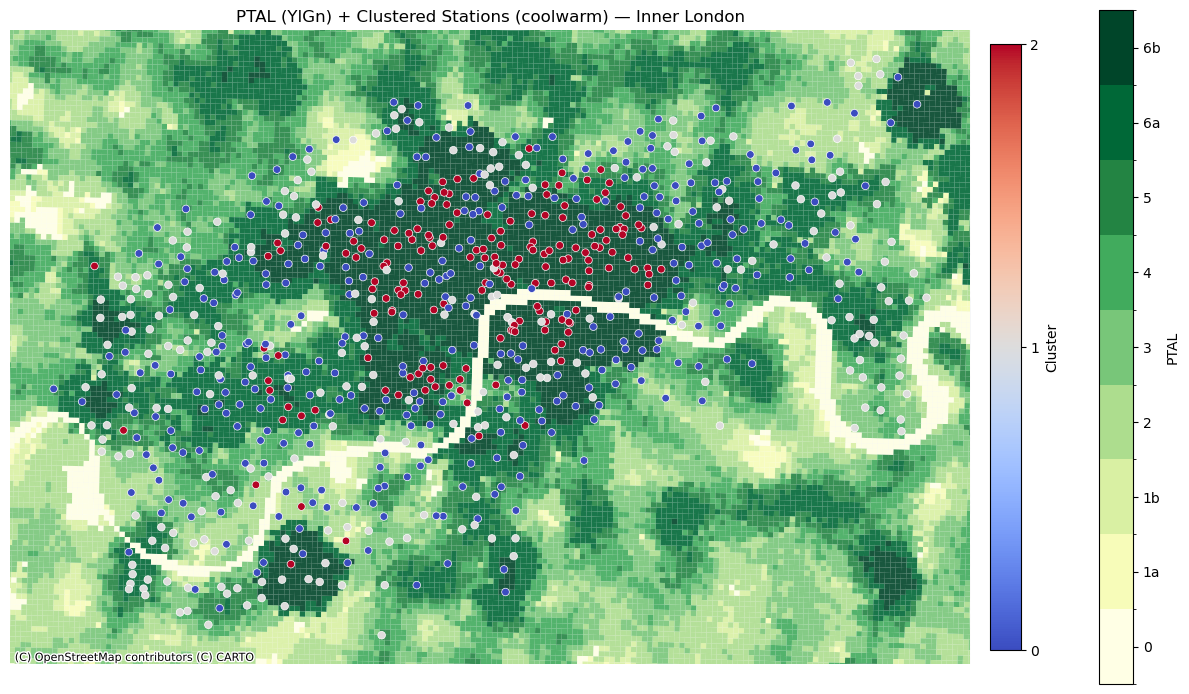

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib import cm, colors

# 1) 投到3857（与底图/参考范围一致）
ptal3857     = ptal.to_crs(3857)
stations3857 = stations.to_crs(3857)

# 2) PTAL 映射为离散等级（0,1a,1b,2,3,4,5,6a,6b → 0..8）
ptal_order = ["0","1a","1b","2","3","4","5","6a","6b"]
ptal_map   = {k:i for i,k in enumerate(ptal_order)}
ptal3857["PTAL_cls"] = ptal3857[ptal_field].astype(str).str.strip()
ptal3857 = ptal3857[ptal3857["PTAL_cls"].isin(ptal_order)]
ptal3857["PTAL_idx"] = ptal3857["PTAL_cls"].map(ptal_map).astype(int)

# 3) 色带：PTAL 用 YlGn（黄→绿，高对比）；簇用你已初始化的 coolwarm 渐变
cmap_ptal = cm.get_cmap("YlGn", len(ptal_order))  # 也可换 "viridis" 更接近你截图
norm_ptal = colors.BoundaryNorm(np.arange(-0.5, len(ptal_order)+0.5, 1), len(ptal_order))

fig, ax = plt.subplots(figsize=(12,8))

# 4) 先画PTAL（去描边，提高清晰度）
ptal3857.plot(column="PTAL_idx", ax=ax, cmap=cmap_ptal, norm=norm_ptal,
              alpha=0.9, linewidth=0)

# 5) 再画簇（coolwarm 渐变 + 连续色带）
stations3857.plot(
    ax=ax,
    column="cluster",
    cmap=cmap_cls_grad,          # ← 用初始化好的渐变 cmap
    norm=norm_cls_grad,          # ← 用连续规范化
    markersize=30,
    edgecolor="white", linewidth=0.5,
    legend=False
)


# 6) 固定为你抓到的内伦敦视野
apply_inner_extent(ax)  # 或：ax.set_xlim(*INNER_EXTENT_3857["xlim"]); ax.set_ylim(*INNER_EXTENT_3857["ylim"])

# 7) 底图淡化（不想要可去掉）
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.20)

# 8) 两条色带：PTAL（离散刻度 0/1a/…/6b） + 簇（连续刻度）
sm_ptal = plt.cm.ScalarMappable(cmap=cmap_ptal, norm=norm_ptal); sm_ptal.set_array([])
cbar_ptal = fig.colorbar(sm_ptal, ax=ax, fraction=0.03, pad=0.07, ticks=range(len(ptal_order)))
cbar_ptal.ax.set_yticklabels(ptal_order); cbar_ptal.set_label("PTAL")

add_cluster_colorbar_grad(fig, ax, label="Cluster")  # 你已定义的函数：coolwarm 渐变色带

ax.set_axis_off()
ax.set_title("PTAL (YlGn) + Clustered Stations (coolwarm) — Inner London")
plt.tight_layout(); plt.show()


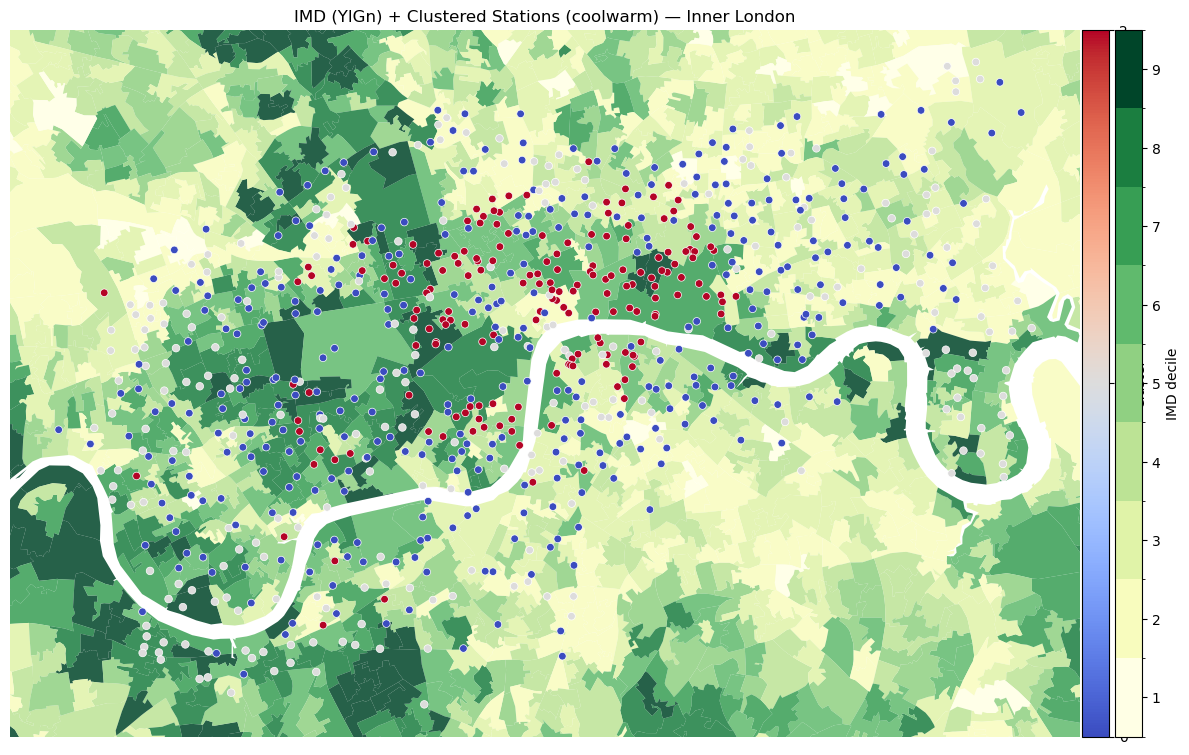

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 投到3857
imd3857      = imd.to_crs(3857)
stations3857 = stations.to_crs(3857)

# IMD：1–10 离散刻度（YlGn）
cmap_imd = plt.colormaps['YlGn'].resampled(10)
norm_imd = colors.BoundaryNorm(np.arange(0.5, 10.5, 1), cmap_imd.N)

fig, ax = plt.subplots(figsize=(12, 8))

# 画IMD（不再用 legend=True，避免胖色带）
imd3857.plot(column=imd_field, ax=ax, cmap=cmap_imd, norm=norm_imd,
             alpha=0.85, linewidth=0)

# 画簇（coolwarm 渐变）
stations3857.plot(
    ax=ax,
    column="cluster",
    cmap=cmap_cls_grad,          # ← 用初始化好的渐变 cmap
    norm=norm_cls_grad,          # ← 用连续规范化
    markersize=30,
    edgecolor="white", linewidth=0.5,
    legend=False
)


# 同范围
apply_inner_extent(ax)   # 或：ax.set_xlim(*INNER_EXTENT_3857["xlim"]); ax.set_ylim(*INNER_EXTENT_3857["ylim"])

# —— 统一瘦色带（两个cax，等宽并排）——
divider = make_axes_locatable(ax)
cax_cluster = divider.append_axes("right", size="2.5%", pad=0.02)   # 贴近主图：Cluster
cax_imd     = divider.append_axes("right", size="2.5%", pad=0.06)   # 外侧：IMD

# Cluster 色带（连续 coolwarm）
sm_cls = plt.cm.ScalarMappable(cmap=cmap_cls_grad, norm=norm_cls_grad); sm_cls.set_array([])
ticks_cluster = np.sort(stations["cluster"].dropna().unique())
fig.colorbar(sm_cls, cax=cax_cluster, ticks=ticks_cluster).set_label("Cluster")

# IMD 色带（离散 1–10）
sm_imd = plt.cm.ScalarMappable(cmap=cmap_imd, norm=norm_imd); sm_imd.set_array([])
fig.colorbar(sm_imd, cax=cax_imd, ticks=range(1,11)).set_label("IMD decile")

ax.set_axis_off()
ax.set_title("IMD (YlGn) + Clustered Stations (coolwarm) — Inner London")
plt.tight_layout(); plt.show()


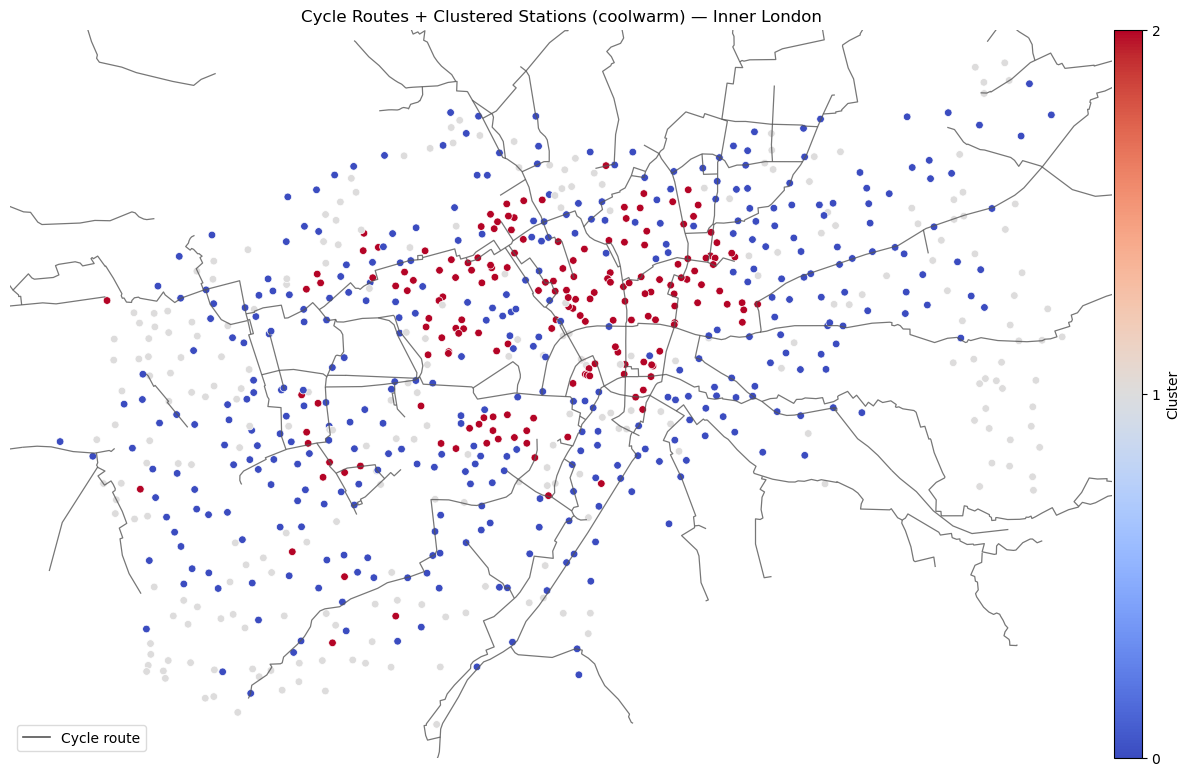

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

cycle3857    = cycle.to_crs(3857)
stations3857 = stations.to_crs(3857)

fig, ax = plt.subplots(figsize=(12, 8))

# 骑行线路（中性灰）
route_color = "#555555"
cycle3857.plot(ax=ax, color=route_color, linewidth=0.9, alpha=0.8)

# 画簇（coolwarm 渐变）
stations3857.plot(
    ax=ax,
    column="cluster",
    cmap=cmap_cls_grad,          # ← 用初始化好的渐变 cmap
    norm=norm_cls_grad,          # ← 用连续规范化
    markersize=30,
    edgecolor="white", linewidth=0.5,
    legend=False
)

apply_inner_extent(ax)

# 统一瘦色带（只放Cluster一条）
divider = make_axes_locatable(ax)
cax_cluster = divider.append_axes("right", size="2.5%", pad=0.02)
sm_cls = plt.cm.ScalarMappable(cmap=cmap_cls_grad, norm=norm_cls_grad); sm_cls.set_array([])
ticks_cluster = np.sort(stations["cluster"].dropna().unique())
fig.colorbar(sm_cls, cax=cax_cluster, ticks=ticks_cluster).set_label("Cluster")

# 小图例：骑行线路
ax.legend([Line2D([0],[0], color=route_color, lw=1.2)], ["Cycle route"],
          loc="lower left", frameon=True, framealpha=0.7)

ax.set_axis_off()
ax.set_title("Cycle Routes + Clustered Stations (coolwarm) — Inner London")
plt.tight_layout(); plt.show()


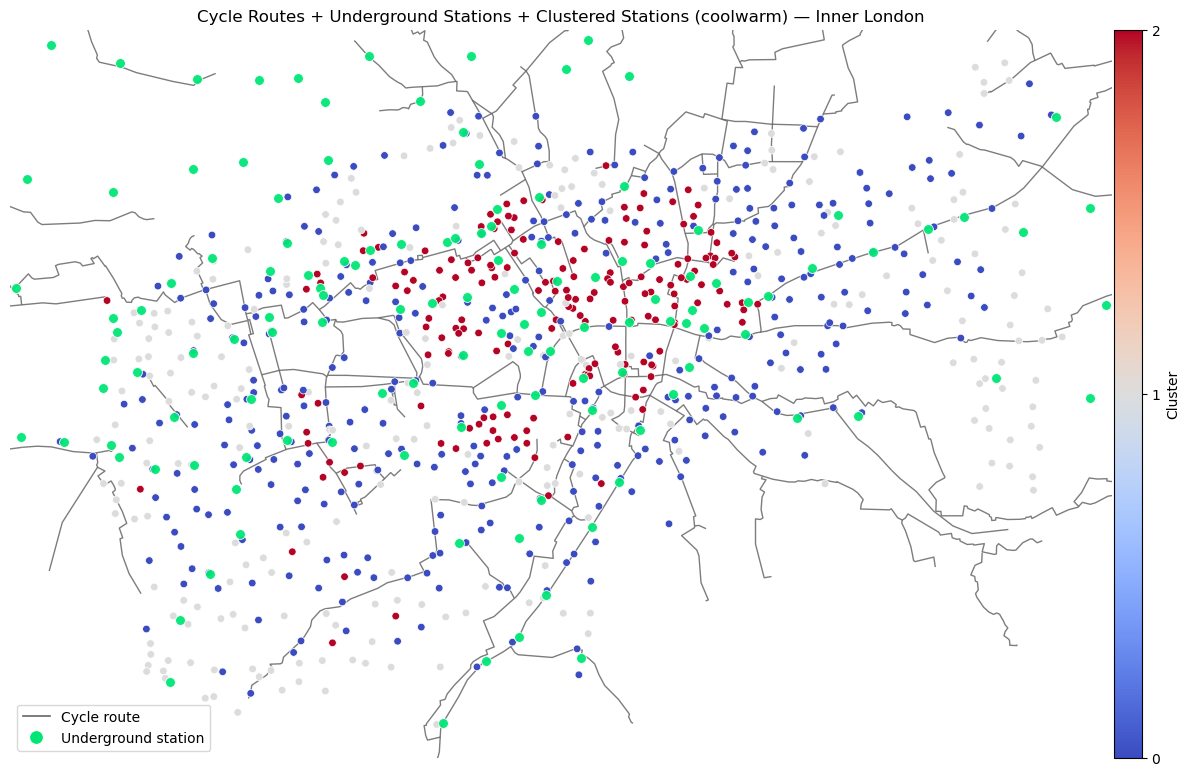

In [23]:
# === Cycle Routes + Underground Stations + Clustered Stations ===
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

# 1) 投到 3857（与 basemap / 参考范围一致）
cycle3857    = cycle.to_crs(3857)
tube3857     = tube.to_crs(3857)
stations3857 = stations.to_crs(3857)

fig, ax = plt.subplots(figsize=(12, 8))

# 2) 底层：骑行线路（中性灰）
route_color = "#666666"
cycle3857.plot(ax=ax, color=route_color, linewidth=1.0, alpha=0.85, zorder=1)

# 3) 中层：簇点（coolwarm 渐变 + 连续色带；适当缩小以突出地铁站）
stations3857.plot(
    ax=ax,
    column="cluster",
    cmap=cmap_cls_grad,          # ← 用初始化好的渐变 cmap
    norm=norm_cls_grad,          # ← 用连续规范化
    markersize=30,
    edgecolor="white", linewidth=0.5,
    legend=False
)


# 4) 顶层：地铁站（亮绿色 + 更大点 + 白色描边）
tube_green = "#00E676"  # 亮绿色
tube3857.plot(
    ax=ax,
    color=tube_green, markersize=50,  # ← 更大
    edgecolor="white", linewidth=0.6,
    alpha=0.95, zorder=3
)

# 5) 统一视野（与你抓到的 INNER_EXTENT_3857 一致）
apply_inner_extent(ax)
# 若没有函数，可用：
# ax.set_xlim(*INNER_EXTENT_3857["xlim"]); ax.set_ylim(*INNER_EXTENT_3857["ylim"])

# 6) 右侧细窄色带（只放 Cluster 一条，和 PTAL/IMD 保持同样风格/宽度）
divider = make_axes_locatable(ax)
cax_cluster = divider.append_axes("right", size="2.5%", pad=0.02)

from matplotlib import cm, colors
sm_cls = cm.ScalarMappable(cmap=cmap_cls_grad, norm=norm_cls_grad); sm_cls.set_array([])
ticks_cluster = np.sort(stations["cluster"].dropna().unique())
fig.colorbar(sm_cls, cax=cax_cluster, ticks=ticks_cluster).set_label("Cluster")

# 7) 简洁图例：骑行线路 & 地铁站
legend_handles = [
    Line2D([0],[0], color=route_color, lw=1.2, label="Cycle route"),
    Line2D([0],[0], marker='o', linestyle='None', markersize=10,
           markerfacecolor=tube_green, markeredgecolor="white", markeredgewidth=0.8,
           label="Underground station"),
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True, framealpha=0.75)

ax.set_axis_off()
ax.set_title("Cycle Routes + Underground Stations + Clustered Stations (coolwarm) — Inner London")
plt.tight_layout(); plt.show()


In [28]:
# === Merge policy features into clustered stations (robust, single cell) ===
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from pathlib import Path

# --- 如果此格独立运行，确保这5个图层已在内存；否则取消下面注释按你的路径读入 ---
# ptal   = gpd.read_file(PTAL_PATH)
# imd    = gpd.read_file(IMD_PATH)
# cycle  = gpd.read_file(CYCLE_ROUTES_PATH)
# tube   = gpd.read_file(UNDERGROUND_PATH)
# stations 已在内存（若是 CSV，请先转 GeoDataFrame）

def to_bng(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """投影到 EPSG:27700；若无 CRS，先假定 WGS84。"""
    if gdf.crs is None:
        gdf = gdf.set_crs(4326)
    return gdf.to_crs(27700)

# ——— 1) 标准化 stations，确保有 station_id/geometry，且坐标=27700（米）
if not isinstance(stations, gpd.GeoDataFrame):
    # 兜底：把 DataFrame 转点图层（经纬度列名自动识别）
    lon_col = next((c for c in ["lon","longitude","x","lng","LONGITUDE"] if c in stations.columns), None)
    lat_col = next((c for c in ["lat","latitude","y","LATITUDE"] if c in stations.columns), None)
    assert lon_col and lat_col, "不能识别经纬度列；请确保有 lon/lat 或 longitude/latitude"
    stations = gpd.GeoDataFrame(
        stations.rename(columns={lon_col:"lon", lat_col:"lat"}),
        geometry=gpd.points_from_xy(stations[lon_col], stations[lat_col]),
        crs=4326
    )

# 统一 station_id
if "station_id" not in stations.columns:
    if "id" in stations.columns:
        stations = stations.rename(columns={"id":"station_id"})
    else:
        stations["station_id"] = np.arange(len(stations))

stations_bng = to_bng(stations.copy())
ptal_bng     = to_bng(ptal.copy())
imd_bng      = to_bng(imd.copy())
cycle_bng    = to_bng(cycle.copy())
tube_bng     = to_bng(tube.copy())

# ——— 2) 找字段名（兼容不同发布版本）
ptal_field = next((c for c in ptal_bng.columns if "PTAL" in c.upper()), None)
imd_field  = next((c for c in imd_bng.columns  if "DECILE" in c.upper() or "QUINTILE" in c.upper()), None)
assert ptal_field is not None, "没找到 PTAL 字段（列名里应包含 'PTAL'）"
assert imd_field  is not None, "没找到 IMD 字段（列名里应包含 'decile' 或 'quintile'）"
print("PTAL field:", ptal_field, "| IMD field:", imd_field)

# ——— 3) PTAL 点落格（100m）
ptal_keep = ptal_bng[[ptal_field, "geometry"]].copy()
tmp = gpd.sjoin(stations_bng, ptal_keep, how="left", predicate="intersects")
tmp = tmp.drop(columns=[col for col in tmp.columns if col.startswith("index_")], errors="ignore")
tmp["PTAL_point_class"] = tmp[ptal_field].astype(str).str.strip()

# ——— 3b) PTAL 250m 缓冲区的“面积加权众数”（覆盖面积最大的等级）
ptal_order = ["0","1a","1b","2","3","4","5","6a","6b"]
ptal_map   = {k:i for i,k in enumerate(ptal_order)}

buffers = stations_bng[["station_id","geometry"]].copy()
buffers["geometry"] = buffers.buffer(250)

inter = gpd.overlay(buffers, ptal_keep, how="intersection")
if not inter.empty:
    inter["area"] = inter.area
    inter["PTAL_cls"] = inter[ptal_field].astype(str).str.strip()
    wmode = (inter.groupby(["station_id","PTAL_cls"])["area"].sum()
                  .reset_index()
                  .sort_values(["station_id","area"], ascending=[True,False])
                  .drop_duplicates("station_id")
                  .rename(columns={"PTAL_cls":"PTAL_mean250_class"}))[["station_id","PTAL_mean250_class"]]
    tmp = tmp.merge(wmode, on="station_id", how="left")
else:
    tmp["PTAL_mean250_class"] = tmp["PTAL_point_class"]  # 无覆盖时退化为点值

# 数值化（0..8）
tmp["PTAL_point_idx"]   = tmp["PTAL_point_class"].map(ptal_map)
tmp["PTAL_mean250_idx"] = tmp["PTAL_mean250_class"].map(ptal_map)

# ——— 4) IMD：点落 LSOA
imd_keep = imd_bng[[imd_field, "geometry"]].copy()
tmp = gpd.sjoin(tmp, imd_keep, how="left", predicate="intersects")
tmp = tmp.drop(columns=[col for col in tmp.columns if col.startswith("index_")], errors="ignore")
tmp = tmp.rename(columns={imd_field:"IMD_decile"})

# ——— 5) 最近距离（米）：Cycle Routes（线） & Underground（点）
tmp = gpd.sjoin_nearest(tmp, cycle_bng[["geometry"]], how="left", distance_col="dist_cycle_m")
tmp = tmp.drop(columns=[col for col in tmp.columns if col.startswith("index_")], errors="ignore")
tmp["within250_cycle"] = (tmp["dist_cycle_m"] <= 250).astype(int)

tmp = gpd.sjoin_nearest(tmp, tube_bng[["geometry"]], how="left", distance_col="dist_underground_m")
tmp = tmp.drop(columns=[col for col in tmp.columns if col.startswith("index_")], errors="ignore")
tmp["within500_rail"] = (tmp["dist_underground_m"] <= 500).astype(int)

# ——— 6) 选列 & 导出
keep_cols = [
    "station_id",
    "station_name" if "station_name" in tmp.columns else None,
    "cluster" if "cluster" in tmp.columns else None,
    "PTAL_point_class","PTAL_point_idx",
    "PTAL_mean250_class","PTAL_mean250_idx",
    "IMD_decile",
    "dist_cycle_m","within250_cycle",
    "dist_underground_m","within500_rail",
]
keep_cols = [c for c in keep_cols if c is not None] + ["geometry"]
final_gdf = tmp[keep_cols].copy()

OUTDIR = Path("0_try2_data"); OUTDIR.mkdir(exist_ok=True)
final_gdf.to_file(OUTDIR / "stations_policy_overlay.geojson", driver="GeoJSON")
final_gdf.drop(columns="geometry").to_csv(OUTDIR / "stations_policy_overlay.csv", index=False)

print("✓ Done")
print("→", OUTDIR / "stations_policy_overlay.geojson")
print("→", OUTDIR / "stations_policy_overlay.csv")
display(final_gdf.head(5))

PTAL field: PTAL_2023 | IMD field: IMD_Decile
✓ Done
→ 0_try2_data/stations_policy_overlay.geojson
→ 0_try2_data/stations_policy_overlay.csv


,station_id,station_name,cluster,PTAL_point_class,PTAL_point_idx,PTAL_mean250_class,PTAL_mean250_idx,IMD_decile,dist_cycle_m,within250_cycle,dist_underground_m,within500_rail,geometry
0,BikePoints_864,"Abbey Orchard Street, Westminster",2,6b,8,6b,8,2.0,329.136793,0,190.830827,1,POINT (529754.807 179340.877)
1,BikePoints_559,"Abbotsbury Road, Holland Park",1,4,5,3,4,8.0,402.314229,0,496.854519,1,POINT (524617.372 179575.794)
2,BikePoints_394,"Aberdeen Place, St. John's Wood",0,4,5,4,5,1.0,979.282518,0,538.765449,0,POINT (526615.285 182232.781)
3,BikePoints_554,"Aberfeldy Street, Poplar",1,3,4,3,4,2.0,376.147569,0,948.437760,0,POINT (538484.162 181287.471)
4,BikePoints_583,"Abingdon Green, Westminster",2,6a,7,6a,7,5.0,339.773412,0,370.675601,1,POINT (530181.66 179297.819)


In [29]:
# === Merge: policy overlay + clustering table ===
import pandas as pd
from pathlib import Path

# 1) 路径（按你的文件名改）
overlay_path = Path("0_try2_data/stations_policy_overlay.csv")     # 上一步生成的政策叠加结果
clusters_path = Path("0_try2_data/kmeans3_cluster.csv")           # 你的聚类指标表

# 2) 读取
overlay  = pd.read_csv(overlay_path)
clusters = pd.read_csv(clusters_path)

# 3) 统一主键列名
if "station_id" not in overlay.columns and "id" in overlay.columns:
    overlay = overlay.rename(columns={"id":"station_id"})
if "station_id" not in clusters.columns and "id" in clusters.columns:
    clusters = clusters.rename(columns={"id":"station_id"})

assert "station_id" in overlay.columns,  "overlay 缺少 station_id/id 列"
assert "station_id" in clusters.columns, "clusters 缺少 station_id/id 列"

# 4) 去重（以主键为准）
overlay_u  = overlay.drop_duplicates(subset=["station_id"]).copy()
clusters_u = clusters.drop_duplicates(subset=["station_id"]).copy()

# 5) 合并（inner 保证两边都存在；若要保留 overlay 全量，可用 how='left'）
merged = overlay_u.merge(
    clusters_u,
    on="station_id",
    how="inner",
    suffixes=("_overlay", "_cluster")
)

# 6) 质量检查：未匹配统计
miss_overlay_to_clusters = overlay_u.loc[~overlay_u["station_id"].isin(clusters_u["station_id"])].shape[0]
miss_clusters_to_overlay = clusters_u.loc[~clusters_u["station_id"].isin(overlay_u["station_id"])].shape[0]
print(f"overlay 行数（去重后）：{len(overlay_u)}")
print(f"clusters 行数（去重后）：{len(clusters_u)}")
print(f"合并后行数（inner）：{len(merged)}")
print(f"overlay->clusters 未匹配：{miss_overlay_to_clusters}")
print(f"clusters->overlay 未匹配：{miss_clusters_to_overlay}")

# 7) 列顺序（把关键字段放前面）
front = ["station_id"]
for name_col in ["station_name","startstation_name"]:
    if name_col in merged.columns: front.append(name_col)
if "cluster" in merged.columns: front.append("cluster")

policy_cols = [
    "PTAL_point_class","PTAL_point_idx",
    "PTAL_mean250_class","PTAL_mean250_idx",
    "IMD_decile","dist_cycle_m","within250_cycle",
    "dist_underground_m","within500_rail"
]
front += [c for c in policy_cols if c in merged.columns]

rest = [c for c in merged.columns if c not in front]
merged = merged[front + rest]

# 8) 导出
outdir = Path("0_try2_data"); outdir.mkdir(exist_ok=True)
out_csv = outdir / "stations_merged_full.csv"
merged.to_csv(out_csv, index=False)
print("已保存：", out_csv)

overlay 行数（去重后）：795
clusters 行数（去重后）：795
合并后行数（inner）：795
overlay->clusters 未匹配：0
clusters->overlay 未匹配：0
已保存： 0_try2_data/stations_merged_full.csv


In [30]:
import re, pandas as pd

df = pd.read_csv("0_try2_data/stations_merged_full.csv")

# 把可能的簇列合并到一个列
cand = [c for c in df.columns if re.fullmatch(r"(cluster|簇|cluster_overlay|cluster_cluster|cluster_x|cluster_y)", c)]
df["cluster"] = pd.to_numeric(pd.concat([df[c] for c in cand if c in df.columns], axis=1).bfill(axis=1).iloc[:,0],
                              errors="coerce").astype("Int64")

# 删掉冗余簇列（保留统一后的 cluster）
df = df.drop(columns=[c for c in cand if c != "cluster"], errors="ignore")

df.to_csv("0_try2_data/stations_merged_full_fixed.csv", index=False)
print("OK -> 0_try2_data/stations_merged_full_fixed.csv")


OK -> 0_try2_data/stations_merged_full_fixed.csv


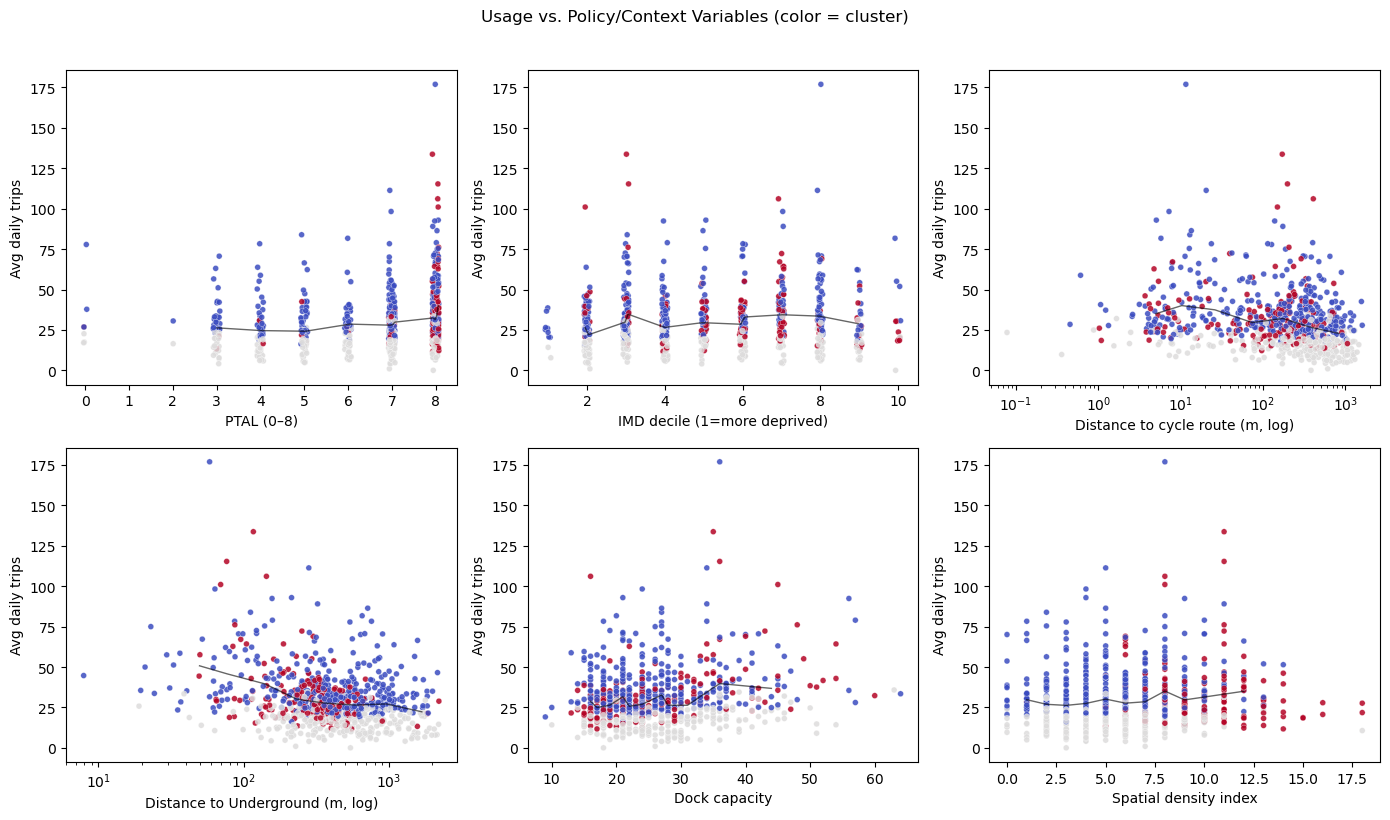

In [31]:
# ==== Scatter panels: y=usage, x in [PTAL/IMD/distances/capacity/...], color by cluster (coolwarm) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# 1) 读合并表（如果你已经在内存有 df，直接跳过这行）
df = pd.read_csv("0_try2_data/stations_merged_full_fixed.csv")  # 如果文件名不同请改

# 2) 保障 cluster 为数值；若你已在前面初始化过 cmap/norm，这段会自动复用
df["cluster"] = pd.to_numeric(df["cluster"], errors="coerce")
clusters = np.sort(df["cluster"].dropna().unique())

try:
    cmap_cls_grad, norm_cls_grad  # 已经有就直接用
except NameError:
    cmap_cls_grad = cm.get_cmap("coolwarm")
    norm_cls_grad = colors.Normalize(vmin=float(clusters.min()), vmax=float(clusters.max()))

# 3) 小工具：画一个面板（含可选对数X、轻微抖动、全样本分箱均值的细趋势线）
def scatter_panel(ax, df, x, y="avg_daily_trips", logx=False, jitter=False, xlabel=None):
    cols = [c for c in [x, y, "cluster"] if c in df.columns]
    d = df[cols].dropna().copy()
    if jitter:
        # 对离散x加一点随机抖动（便于看重叠）
        d[x] = d[x] + (np.random.rand(len(d))-0.5)*0.15
    sc = ax.scatter(d[x], d[y],
                    c=d["cluster"], cmap=cmap_cls_grad, norm=norm_cls_grad,
                    s=18, alpha=0.85, edgecolors="white", linewidths=0.25)
    if logx:
        ax.set_xscale("log")
    ax.set_xlabel(xlabel or x)
    ax.set_ylabel("Avg daily trips" if y=="avg_daily_trips" else y)

    # 轻量趋势：按x分箱的均值曲线（总体，不分簇），避免拟合假象
    try:
        if logx:
            edges = np.geomspace(d[x].min(), d[x].max(), 12)
        else:
            edges = np.quantile(d[x], np.linspace(0,1,12))
        xy = []
        for i in range(len(edges)-1):
            seg = d[(d[x]>=edges[i]) & (d[x]<edges[i+1])]
            if len(seg) >= 10:
                xy.append((seg[x].median(), seg[y].mean()))
        if len(xy) >= 2:
            xm, ym = zip(*xy)
            ax.plot(xm, ym, color="k", lw=1, alpha=0.6)
    except Exception:
        pass
    return sc

# 4) 要画的X变量（按你现有列名自动跳过缺失）
candidates = [
    ("PTAL_mean250_idx",  False, True,  "PTAL (0–8)"),
    ("IMD_decile",        False, True,  "IMD decile (1=more deprived)"),
    ("dist_cycle_m",      True,  False, "Distance to cycle route (m, log)"),
    ("dist_underground_m",True,  False, "Distance to Underground (m, log)"),
    ("nbDocks",           False, False, "Dock capacity"),
    ("spatial_density_index", False, False, "Spatial density index"),
    # 你还可以加：("turnover_rate", False, False, "Turnover rate"),
    #            ("weekend_usage_ratio", False, False, "Weekend usage ratio"),
]

# 5) 生成面板
valid = [(x,logx,jit,lab) for (x,logx,jit,lab) in candidates if x in df.columns]
n = len(valid)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(14, 8))
axes = axes.ravel()

for ax, (x, logx, jit, lab) in zip(axes, valid):
    scatter_panel(ax, df, x, y="avg_daily_trips", logx=logx, jitter=jit, xlabel=lab)

# 用同一条簇色带（与地图一致）
sm = plt.cm.ScalarMappable(cmap=cmap_cls_grad, norm=norm_cls_grad); sm.set_array([])


# 把多余空轴关掉（万一不足6个）
for ax in axes[len(valid):]:
    ax.set_visible(False)

fig.suptitle("Usage vs. Policy/Context Variables (color = cluster)", y=1.02)
fig.tight_layout()
plt.show()
